# Deep Dream

- Andrei Dugăeșescu

<br>

DeepDream is an experiment designed to visualize the patterns a neural network has learned. Much like a child looking at clouds and seeing various shapes, DeepDream exaggerates and amplifies the patterns it detects in an image.

It achieves this by passing an image through the network and calculating the gradient of the image with respect to the activations of a specific layer. The image is then altered to amplify these activations, enhancing the patterns perceived by the network and creating a dream-like effect. This technique was dubbed "Inceptionism" because  it originated from a CNN codenamed "Inception", itself a reference to the film of the same name.

<div align="center">
  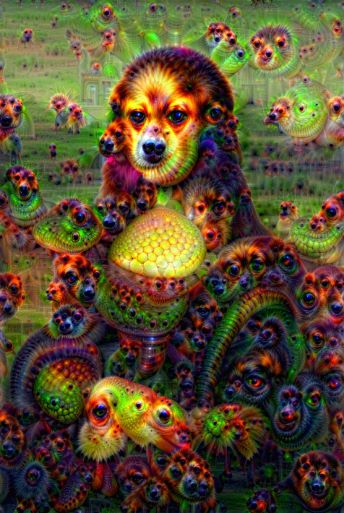
</div>

This tutorial shows how to create dream-like appearances reminiscent of a psychedelic experience in the form of deliberately overprocessed images such as the [Mona Lisa](https://en.wikipedia.org/wiki/DeepDream) above.

In [1]:
from torch.utils.hooks import RemovableHandle as Hook
from torchvision import transforms as tf
from IPython.display import display
from typing import Callable
from tqdm.auto import tqdm
from pathlib import Path
from torch import Tensor
from PIL import Image

import matplotlib.pyplot as plt
import scipy.ndimage as nd
import torch.nn as nn
import numpy as np
import torchvision
import random
import torch
import os

In [2]:
BASE_PATH = Path('images/deepdream')

## Set seed for reproducibility 

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Loading the model - pretrained VGG19

In [5]:
model = torchvision.models.vgg19(weights='DEFAULT')
model = model.to(device)
model = model.eval()

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Dreaming images

Constructing the "dream" is a simple process. DeepDream is just a series of gradient ascent steps that try to maximize the L2 norm of the activations of a target DNN layer. To increase the perceptual quality of the final output it is recommended to:

- normalize the magnitude of the gradient ascent steps
- apply the ascent across multiple scales (called **octaves**)

<div align="center">
  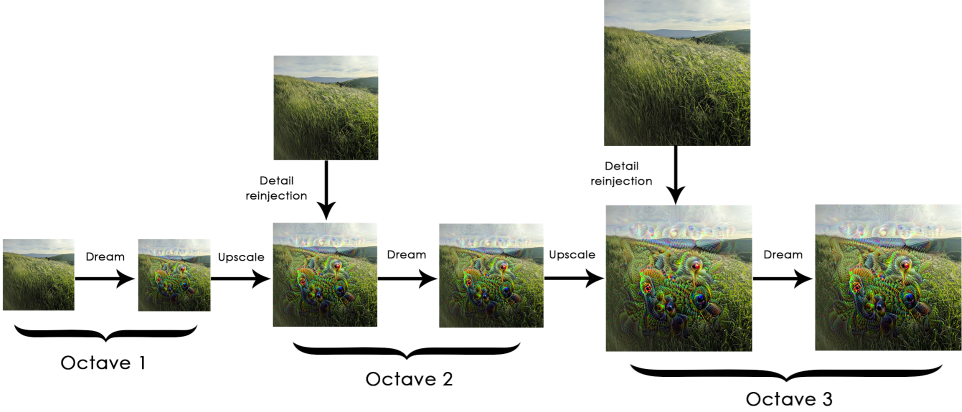
</div>


In [7]:
def L2(x: Tensor) -> float:
    return torch.norm(x)

In [8]:
class DeepDream:
    
    def __init__(
        self, 
        model: nn.Module, 
        target_layer: int, 
        device: torch.device = device,
        criterion: Callable[[Tensor], float] = L2
    ) -> None:
        
        self.device = device
        
        layers = list(model.features.children())
        self.model = nn.Sequential(*layers[:(target_layer + 1)])
        
        self.model = self.model.to(self.device)
        self.model = self.model.eval()
        
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        
        self.preprocess = tf.Compose([tf.ToTensor(), tf.Normalize(mean, std)])
        self.mean = torch.tensor(mean, device=self.device)
        self.std  = torch.tensor(std, device=self.device)
        
        self.criterion = criterion
    
    def deprocess(self, image: np.ndarray) -> np.ndarray:
        mean = self.mean.cpu().numpy()
        std  = self.std.cpu().numpy()
        
        image = image.squeeze().transpose(1, 2, 0)
        image = image * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
        
        image = np.clip(image, 0, 1)
        image *= 255
        image = np.clip(image, 0, 255).astype('uint8')
        return image
    
    def construct_octaves(
        self, 
        image: Image.Image, 
        octave_scale: float, 
        n_octaves: int
    ) -> list[np.ndarray]:
        
        image = self.preprocess(image).unsqueeze(0).cpu().numpy()
        
        octaves = [image]
        for _ in range(n_octaves - 1):
            octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))
        return octaves
    
    def clip(self, x: Tensor) -> Tensor:
        min_vals = (-self.mean / self.std).unsqueeze(1).unsqueeze(2)
        max_vals = ((1 - self.mean) / self.std).unsqueeze(1).unsqueeze(2)
        return torch.clamp(x, min_vals, max_vals).to(torch.float32)
    
    def gradient_ascent(self, image: np.ndarray, iterations: int, lr: float) -> np.ndarray:
        
        image = torch.tensor(image, device=self.device)
        
        for _ in range(iterations):
            image = image.requires_grad_()
            
            ### TODO: Implement the DeepDream Gradient Ascent step ###
            
            # TODO 1: Get the activations of the target layer (since the model
            # is truncated to the target layer, just run a forward pass)
            # out = ...
            
            # TODO 2: Compute the loss (using self.criterion)
            # loss = ...
            
            # Computing the gradients
            loss.backward(retain_graph=True)
            
            # TODO 3: Compute the average absolute gradient of the input
            # avg_grad = ...
            
            # TODO 4: Instead of having a fixed step, the update
            # depends on the magnitude of the gradient
            # norm_lr = ...
            
            # TODO 5: Update the input image using gradient ascent
            # image = image.detach() + ...
            
            # Clip the range of the input
            image = self.clip(image)
            
        return image.detach().cpu().numpy()

    def dream(
        self, 
        image: Image.Image, 
        iterations: int = 20, 
        lr: float = 0.01, 
        octave_scale: float = 1.4,
        n_octaves: int = 10
    ) -> np.ndarray:
        
        octaves = self.construct_octaves(image, octave_scale, n_octaves)
        details = np.zeros_like(octaves[-1])
        
        for i, octave in enumerate(tqdm(octaves[::-1], desc="Dreaming", leave=False)):
            if i > 0:
                details = nd.zoom(details, np.array(octave.shape) / np.array(details.shape), order=1)
            
            input_image = octave + details            
            dreamed_image = self.gradient_ascent(input_image, iterations, lr)
            details = dreamed_image - octave
            
        return self.deprocess(dreamed_image)

<br>

# The image of "our dreams"

Now to actually construct some "dreams" we will use the cloud image form the original [Google post](https://research.google/blog/inceptionism-going-deeper-into-neural-networks/).  

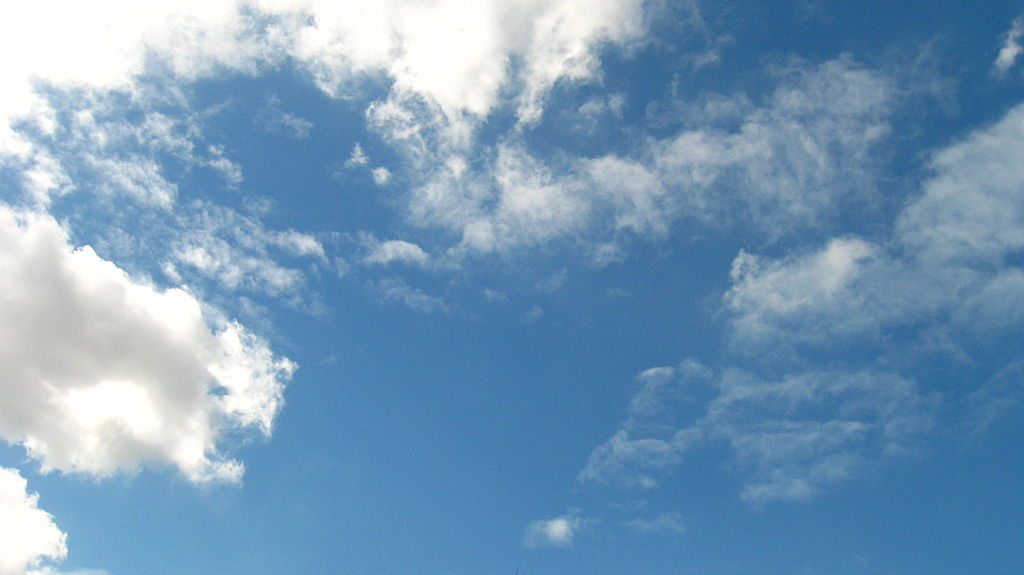

In [9]:
image = Image.open('data/sky1024px.jpg'); image

## Octaves 

In [10]:
dd = DeepDream(model, 0)

octaves = dd.construct_octaves(image, 1.4, 10)
for octave in octaves[::-1]:
    print(octave.shape)

(1, 3, 28, 49)
(1, 3, 39, 69)
(1, 3, 54, 97)
(1, 3, 76, 136)
(1, 3, 107, 190)
(1, 3, 150, 266)
(1, 3, 210, 373)
(1, 3, 294, 522)
(1, 3, 411, 731)
(1, 3, 575, 1024)


In [11]:
def plot_dream(dreamed_image: np.ndarray, filename: str, figsize: tuple[int, int] = (15, 15)) -> None:
    os.makedirs(BASE_PATH, exist_ok=True)
    
    plt.figure(figsize=figsize)
    plt.imshow(dreamed_image)
    plt.axis('off')
    plt.imsave(BASE_PATH/filename, dreamed_image)
    plt.show()

# Layer 10 

In [12]:
%%time
dd = DeepDream(model, 10)
dreamed_image = dd.dream(image, lr=5e-3, octave_scale=1.6, n_octaves=6)

Dreaming:   0%|          | 0/6 [00:00<?, ?it/s]

CPU times: total: 3.89 s
Wall time: 4.89 s


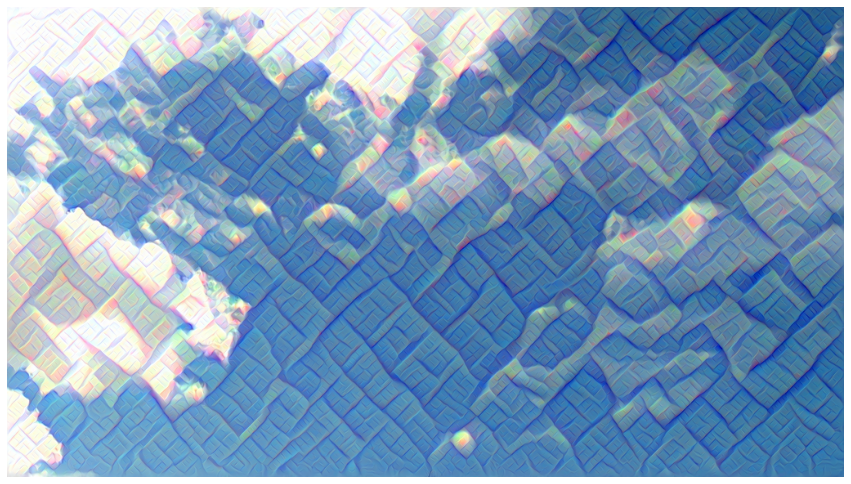

In [13]:
plot_dream(dreamed_image, 'sky_layer10.png')

# Layer 18 

In [14]:
%%time
dd = DeepDream(model, 18)
dreamed_image = dd.dream(image)

Dreaming:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 7.03 s
Wall time: 8.39 s


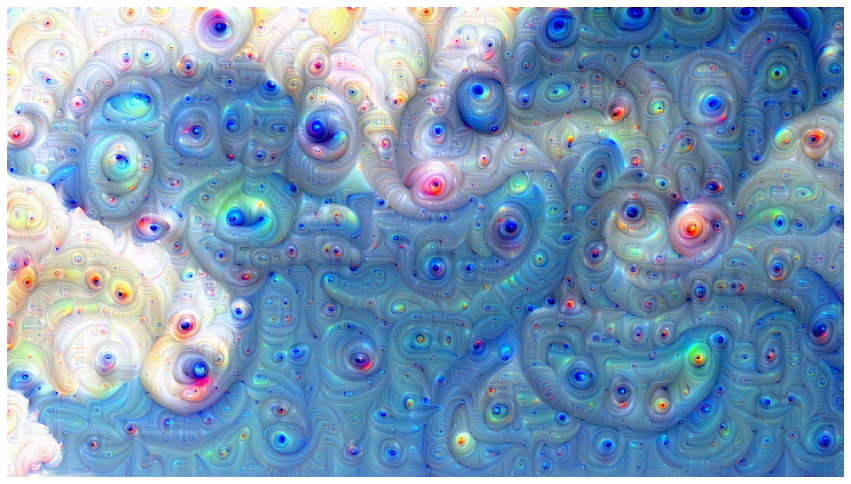

In [15]:
plot_dream(dreamed_image, 'sky_layer18.png')

# Layer 27 

In [16]:
%%time
dd = DeepDream(model, 27)
dreamed_image = dd.dream(image)

Dreaming:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 9.59 s
Wall time: 11.4 s


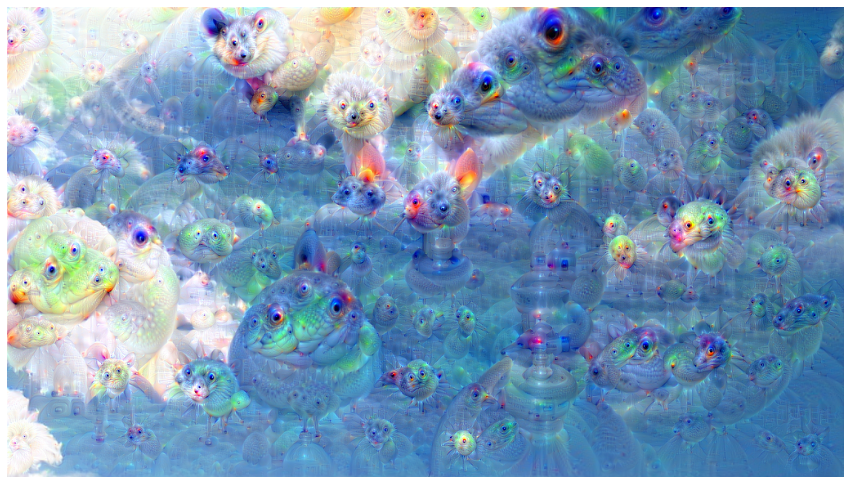

In [17]:
plot_dream(dreamed_image, 'sky_layer27.png')

# Layer 33

In [18]:
%%time
dd = DeepDream(model, 33)
dreamed_image = dd.dream(image, octave_scale=1.2, n_octaves=15)

Dreaming:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 15.9 s
Wall time: 20.2 s


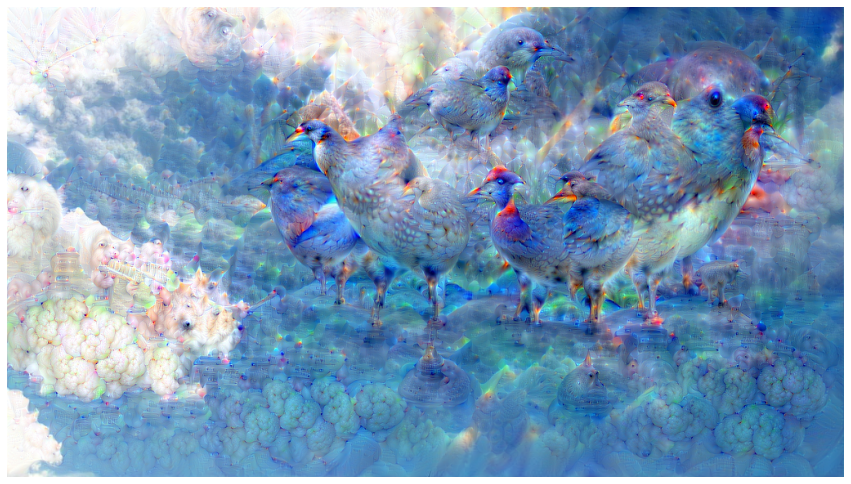

In [19]:
plot_dream(dreamed_image, 'sky_layer33.png')

# What if we dream a dream? 

In [20]:
dd = DeepDream(model, 27)
frame = image
h, w = frame.size
s = 0.05 # scale coefficient

In [21]:
# %%capture 
# os.makedirs(BASE_PATH/'long_dream', exist_ok=True)

# # Run this at own risk (~20min)
# for i in range(100):
#     frame = dd.dream(frame)
#     Image.fromarray(frame).save(BASE_PATH/f'long_dream/sky_layer27_frame{i}.jpg')
#     frame = nd.affine_transform(frame, [1 - s, 1 - s, 1], [h * s / 2, w * s / 2, 0], order=1)

In [22]:
# %%time
# images_dir, gif_path = BASE_PATH/'long_dream', BASE_PATH/'long_dream.gif'
# images = [Image.open(images_dir/f'sky_layer27_frame{i}.jpg') for i in range(100)]
# images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)  # 42s

# Controlling dreams

Instead of maximizing the L2-norm of current image activations, we try to maximize the dot-products between activations of current image, and their correspondences from the guide image.

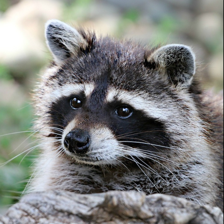

In [23]:
image_raccoon = Image.open('data/raccoon.png').convert('RGB').resize((224, 224))
image_raccoon

In [24]:
def guided_dot_product(
    model: nn.Module, 
    target_layer: int, 
    image: Image.Image
) -> Callable[[Tensor], float]:
    
    dd = DeepDream(model, target_layer)
    
    image_tensor = dd.preprocess(image)[None]
    image_tensor = image_tensor.to(dd.device)
    
    guide_features = dd.model(image_tensor)[0]
    c = guide_features.shape[0]
    
    guide_features = guide_features.view(c, -1)

    def dot_product(features: Tensor) -> float:
        features = features[0].view(c, -1)
        prod = features.T @ guide_features
        return prod.mean()
    
    return dot_product

In [25]:
%%time
criterion = guided_dot_product(model, 27, image_raccoon)
dd = DeepDream(model, 27, criterion=criterion)

dreamed_image = dd.dream(image, lr=2e-2, n_octaves=4)

Dreaming:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: total: 10.8 s
Wall time: 11.4 s


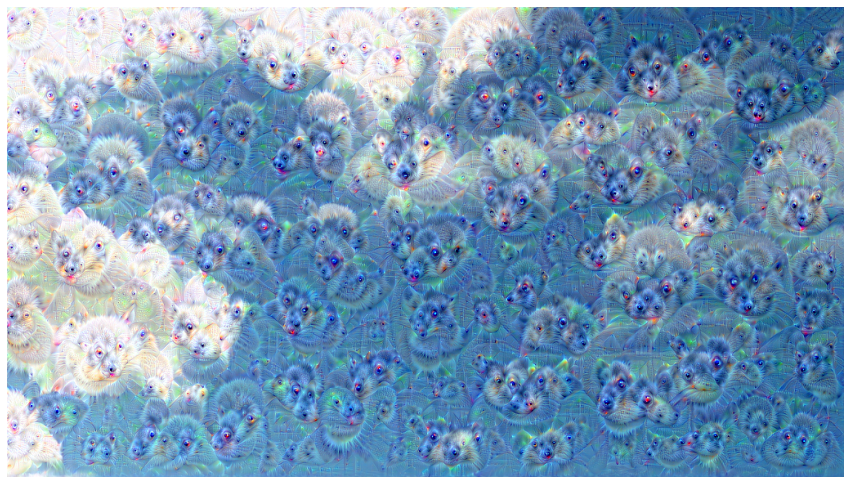

In [26]:
plot_dream(dreamed_image, 'raccoon_layer27.png')